# Text classification

**Patrick Altmeyer**

Final project for deep learning course, Master in Data Science 20/21, BGSE

In [28]:
# Mount google drive 
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/computational_ml_2/computing/neuralNets/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/computational_ml_2/computing/neuralNets/'
/content/drive/MyDrive/computational_ml_2/computing/neuralNets


In [29]:
# Import libraries
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Activation, Dense, Dropout, Embedding,
    Flatten, Input, Convolution1D, MaxPooling1D,
    concatenate, LSTM, SimpleRNN, GRU
)
from tensorflow.keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.models import word2vec
from gensim.models.word2vec import Word2Vec
import os
import pickle
from w2v import train_word2vec
%load_ext rpy2.ipython
rand_state = 42
np.random.seed(rand_state)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Load and preprocess data

In [30]:
embedding_dim = 50
max_sequence_length = 56
max_sequence_length_char = 148

In [31]:
# Load data
dt = pd.read_csv(
    os.path.join("data/data.txt"), sep="\t", header=None,
    names=["text", "labels"]
)

- Not necessary to remove stop words, but perhaps still useful to remove punctuation

In [32]:
def preprocess_text(text):
    text = text.lower()
    text = text.replace('.',' ')
    text = text.replace(',',' ')
    text = text.replace('-',' ')
    text = text.replace('%','')
    text = text.replace(':',' ')
    text = text.replace('(','')
    text = text.replace(')','')
    text = text.replace('\n',' ')
    text = text.replace('[',' ')
    text = text.replace(']',' ')
    text = text.replace('"',' ')
    text = text.replace('  ',' ')
    
    return text

In [33]:
texts = list(map(lambda x: preprocess_text(x), dt.text)) # preprocess
labels = list(dt.labels)

Now we need turn our text samples and labels into tensors that can be fed into a neural network.

In [34]:
# Word-wise:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens (words).' % len(word_index))

# Character-wise:
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(texts)
sequences_char = tokenizer.texts_to_sequences(texts)

char_index = tokenizer.word_index
print('Found %s unique tokens (characters).' % len(char_index))

Found 2071 unique tokens (words).
Found 48 unique tokens (characters).


With the text now tokenized we can use `pad_sequences` to turn the sentences/texts into numerical sequences:

In [35]:
data = pad_sequences(sequences, maxlen=max_sequence_length)
data_char = pad_sequences(sequences_char, maxlen=max_sequence_length_char)

We'll also rearrange the labels slightly:

In [36]:
from keras.utils import to_categorical
labels = to_categorical(np.asarray(labels))

Now both the text data and labels are in an adequate format to be passed to a neural network:

In [37]:
print('Shape of data tensor (words):', data.shape)
print('Shape of data tensor (characters):', data_char.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor (words): (1000, 56)
Shape of data tensor (characters): (1000, 148)
Shape of label tensor: (1000, 2)


## Embeddings

### Pre-trained embeddings - GloVe

Our sample is very small so instead of learning the embeddings from our sample it may be useful to use pre-trained embeddings. For starters we will rely on the smallest global vector embedding available from [GloVe](https://nlp.stanford.edu/projects/glove/), which is still considerable larger than any reasonable embedding we could learn form our sample.

Below we read the 50-$d$ embedding and store dictionary `embeddings_index` containing all words (keys) and their corresponding word vector (values).

In [38]:
GLOVE_DIR = "data/glove/"
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.50d.txt'))
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Now we can use the dictionary of words in our sample created earlier (`word_index`) and match them with their global word vectors if available in `embeddings_index`:

In [39]:
embedding_matrix = np.zeros((len(word_index)+1, embedding_dim))
no_wv_available = []
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # words not found in embedding index will be all-zeros.
    embedding_matrix[i] = embedding_vector
  else:
    no_wv_available.append(word)

We can see that the the shape of the embedding tensor is in line with the sample as expected. For about 5% of the words in our sample we do not have a corresponding word vector.

In [40]:
print('Shape of embedding tensor:', embedding_matrix.shape)
print('No word vectors available for %i out of %i words.' % (len(no_wv_available), len(word_index)))

Shape of embedding tensor: (2072, 50)
No word vectors available for 101 out of 2071 words.


### Visualizing the word vectors

To get a better understanding of our embedded text, we can register the word vectors in a 2-dimensional subspace and  visualise them.

In [41]:
from matplotlib import pylab
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=5, n_components=2, init='pca', n_iter=5000)
# get the T-SNE manifold
two_d_embeddings = tsne.fit_transform(embedding_matrix)

In fact it appears that related words appear close too each other and/or on the same line.

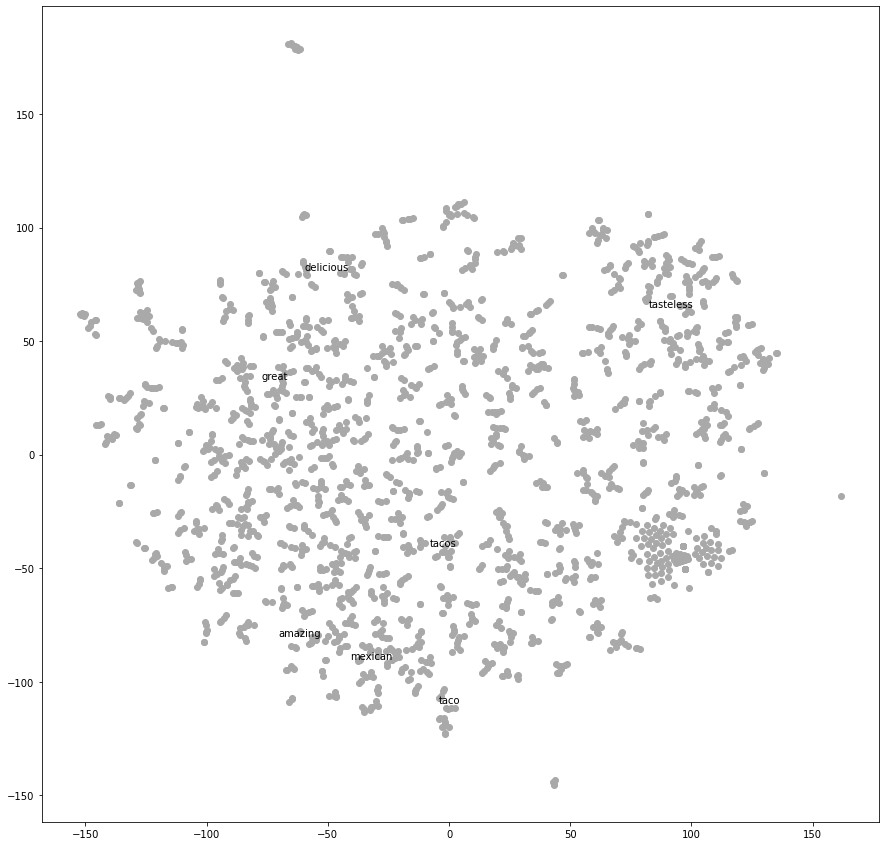

In [42]:
suggested_words = ['delicious', 'amazing', 'great',
                   'tasteless', 'digust',
                   'tacos', 'taco', 'mexican']
all_words = list(word_index.keys())
selected_words = [i for i in suggested_words if i in all_words]

pylab.figure(figsize=(15,15))
# plot all the embeddings and their corresponding words
for i, label in enumerate(all_words):
  x, y = two_d_embeddings[i,:]
  pylab.scatter(x, y, c='darkgray')   
  if label in selected_words:
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                    ha='right', va='bottom',fontsize=10)
        
pylab.show()

# A first run

In this section we will have a first go at the text classification task. We will first attempt the word-wise implementation follows by the character-wise implementation.

## Word-wise

In [43]:
# Model hyper parameters:
filter_sizes = (3, 4)
num_filters = 150
dropout_prob = (0.25, 0.5)
hidden_dims = 150
# Training parameters:
batch_size = 32
num_epochs = 10
val_split = 0.1
# Word2Vec parameters, see train_word2vec
min_word_count = 1  # Minimum word count                        
context = 10        # Context window size  

#### CNN

We retrieve the data:

In [44]:
# Shuffle data
x = data
vocabulary_inv = ['<PAD/>'] + list(word_index.keys())
y = labels
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices].argmax(axis=1)
texts_shuffled = [texts[i] for i in list(shuffle_indices)]
labels_shuffled = [dt.labels[i] for i in list(shuffle_indices)]

We form the embedding layer:

In [45]:
# Embedding:
model_variation = 'glove'
embedding_weights = {
    'glove': [embedding_matrix],
    'non-static': train_word2vec(
        x, vocabulary_inv,
        embedding_dim, min_word_count, 
        context
    ),
    'rand': None
}

embedding_layer = Embedding(
    len(word_index)+1,
    embedding_dim,
    weights=embedding_weights[model_variation],
    input_length=max_sequence_length
)

Loading existing Word2Vec model '50features_1minwords_10context'


We build the model:

In [46]:
graph_in = Input(shape=(max_sequence_length,embedding_dim))

convs = [] # list of flattened convolutions to be passed into network
for fsz in filter_sizes:
    conv = Convolution1D(filters=num_filters,
                         kernel_size=fsz,
                         padding='valid',
                         activation='relu',
                         strides=1)(graph_in)
    pool = MaxPooling1D(pool_size=2)(conv) # selecting largest value
    flatten = Flatten()(pool) # take output of convolution and flatten it
    convs.append(flatten)
    
if len(filter_sizes)>1:
    out = concatenate(convs)
else:
    out = convs[0]

graph = Model(inputs=graph_in, outputs=out)

# main sequential model
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(dropout_prob[0], input_shape=(max_sequence_length,embedding_dim)))
model.add(graph)
model.add(Dense(hidden_dims))
model.add(Dropout(dropout_prob[1]))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid')) # link function

Finally, we compile and run the model. Both in-sample and validation accuracy after 10 epochs are fair, though there seems to be room for improvement.

In [47]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', 
              metrics=['accuracy'])

# Training model
# ==================================================
model.fit(x_shuffled, y_shuffled, batch_size=batch_size,
          epochs=num_epochs, validation_split=val_split, verbose=2)

Epoch 1/10
29/29 - 3s - loss: 0.8516 - accuracy: 0.5189 - val_loss: 0.6644 - val_accuracy: 0.5800
Epoch 2/10
29/29 - 1s - loss: 0.6531 - accuracy: 0.6400 - val_loss: 0.5998 - val_accuracy: 0.6900
Epoch 3/10
29/29 - 1s - loss: 0.5675 - accuracy: 0.7167 - val_loss: 0.5311 - val_accuracy: 0.7200
Epoch 4/10
29/29 - 1s - loss: 0.5081 - accuracy: 0.7456 - val_loss: 0.4913 - val_accuracy: 0.7700
Epoch 5/10
29/29 - 1s - loss: 0.4214 - accuracy: 0.8100 - val_loss: 0.4799 - val_accuracy: 0.7900
Epoch 6/10
29/29 - 1s - loss: 0.3473 - accuracy: 0.8500 - val_loss: 0.4342 - val_accuracy: 0.8200
Epoch 7/10
29/29 - 1s - loss: 0.2905 - accuracy: 0.8756 - val_loss: 0.4692 - val_accuracy: 0.7600
Epoch 8/10
29/29 - 1s - loss: 0.2640 - accuracy: 0.8933 - val_loss: 0.4276 - val_accuracy: 0.8300
Epoch 9/10
29/29 - 1s - loss: 0.2199 - accuracy: 0.9156 - val_loss: 0.4752 - val_accuracy: 0.7900
Epoch 10/10
29/29 - 1s - loss: 0.1623 - accuracy: 0.9433 - val_loss: 0.5782 - val_accuracy: 0.7400


Let's have a quick look at a few sample predictions below:

In [48]:
slice = 10
predicted = model.predict(x_shuffled[:slice])
pd.DataFrame({"sentence": texts_shuffled[:slice],"true": labels_shuffled[:slice], "pred": predicted.flatten()})

,sentence,true,pred
0,worst thai ever,0,0.002733
1,this is an outstanding little restaurant with ...,1,0.999411
2,i consider this theft,0,0.081284
3,i love the fact that everything on their menu ...,1,0.996792
4,the live music on fridays totally blows,0,0.005549
5,there is nothing privileged about working/eati...,0,0.088264
6,we were promptly greeted and seated,1,0.974144
7,the only redeeming quality of the restaurant w...,1,0.995211
8,the turkey and roast beef were bland,0,0.056713
9,i loved the grilled pizza reminded me of legit...,1,0.998257


### RNN

Now let's run a simple LSTM. The results here look somewhat better than for the convolutional network, but since we have not fine tuned yet, it is too early to draw any conclusions as to which approach performs better.

In [49]:
# create the model 
model = Sequential() 
model.add(embedding_layer) 
model.add(LSTM(100)) 
model.add(Flatten()) 
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy']) 

In [50]:
# Training model
# ==================================================
model.fit(x_shuffled, y_shuffled, batch_size=batch_size,
          epochs=num_epochs, validation_split=val_split, verbose=2)

Epoch 1/10
29/29 - 4s - loss: 0.6213 - accuracy: 0.6644 - val_loss: 0.5492 - val_accuracy: 0.7500
Epoch 2/10
29/29 - 2s - loss: 0.4659 - accuracy: 0.7889 - val_loss: 0.4347 - val_accuracy: 0.8100
Epoch 3/10
29/29 - 2s - loss: 0.3499 - accuracy: 0.8678 - val_loss: 0.4178 - val_accuracy: 0.8300
Epoch 4/10
29/29 - 2s - loss: 0.2812 - accuracy: 0.8922 - val_loss: 0.3828 - val_accuracy: 0.8500
Epoch 5/10
29/29 - 2s - loss: 0.2277 - accuracy: 0.9200 - val_loss: 0.3517 - val_accuracy: 0.8600
Epoch 6/10
29/29 - 2s - loss: 0.1812 - accuracy: 0.9333 - val_loss: 0.4356 - val_accuracy: 0.8700
Epoch 7/10
29/29 - 2s - loss: 0.1553 - accuracy: 0.9489 - val_loss: 0.3852 - val_accuracy: 0.8400
Epoch 8/10
29/29 - 2s - loss: 0.1281 - accuracy: 0.9633 - val_loss: 0.3505 - val_accuracy: 0.8900
Epoch 9/10
29/29 - 2s - loss: 0.0941 - accuracy: 0.9789 - val_loss: 0.3710 - val_accuracy: 0.9000
Epoch 10/10
29/29 - 2s - loss: 0.0820 - accuracy: 0.9800 - val_loss: 0.4155 - val_accuracy: 0.8600


Once agains, let us look at a few sample predictions:

In [51]:
slice = 10
predicted = model.predict(x_shuffled[:slice])
pd.DataFrame({"sentence": texts_shuffled[:slice],"true": labels_shuffled[:slice], "pred": predicted.flatten()})

,sentence,true,pred
0,worst thai ever,0,0.009539
1,this is an outstanding little restaurant with ...,1,0.995767
2,i consider this theft,0,0.023814
3,i love the fact that everything on their menu ...,1,0.999728
4,the live music on fridays totally blows,0,0.069973
5,there is nothing privileged about working/eati...,0,0.001029
6,we were promptly greeted and seated,1,0.961458
7,the only redeeming quality of the restaurant w...,1,0.997438
8,the turkey and roast beef were bland,0,0.060890
9,i loved the grilled pizza reminded me of legit...,1,0.998639


## Character-wise

Below follows the character-wise implementation. I will avoide detailed comments to avoid repetition and only state the high-level results here:

- Both the CNN and RNN perform poorly compared to the word-wise implementation.
- The CNN achieve better in-sample accuracy, but validation accuracy is roughly the same for both models.

### CNN

In [52]:
# Shuffle data
x = data_char
vocabulary_inv = ['<PAD/>'] + list(char_index.keys())
y = labels
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices].argmax(axis=1)

In [53]:
# Embedding:
model_variation = 'rand'
embedding_weights = {
    'non-static': train_word2vec(
        x, vocabulary_inv,
        embedding_dim, min_word_count, 
        context
    ),
    'rand': None
}

embedding_layer = Embedding(
    len(char_index)+1,
    embedding_dim,
    weights=embedding_weights[model_variation],
    input_length=max_sequence_length_char
)

Loading existing Word2Vec model '50features_1minwords_10context'


In [54]:
graph_in = Input(shape=(max_sequence_length_char,embedding_dim))

convs = [] # list of flattened convolutions to be passed into network
for fsz in filter_sizes:
    conv = Convolution1D(filters=num_filters,
                         kernel_size=fsz,
                         padding='valid',
                         activation='relu',
                         strides=1)(graph_in)
    pool = MaxPooling1D(pool_size=2)(conv) # selecting largest value
    flatten = Flatten()(pool) # take output of convolution and flatten it
    convs.append(flatten)
    
if len(filter_sizes)>1:
    out = concatenate(convs)
else:
    out = convs[0]

graph = Model(inputs=graph_in, outputs=out)

# main sequential model
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(dropout_prob[0], input_shape=(max_sequence_length_char,embedding_dim)))
model.add(graph)
model.add(Dense(hidden_dims))
model.add(Dropout(dropout_prob[1]))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid')) # link function

In [55]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', 
              metrics=['accuracy'])

# Training model
# ==================================================
model.fit(x_shuffled, y_shuffled, batch_size=batch_size,
          epochs=num_epochs, validation_split=val_split, verbose=2)

Epoch 1/10
29/29 - 4s - loss: 0.7361 - accuracy: 0.5144 - val_loss: 0.6944 - val_accuracy: 0.4600
Epoch 2/10
29/29 - 3s - loss: 0.6831 - accuracy: 0.5667 - val_loss: 0.6779 - val_accuracy: 0.5500
Epoch 3/10
29/29 - 3s - loss: 0.6585 - accuracy: 0.6067 - val_loss: 0.7117 - val_accuracy: 0.5300
Epoch 4/10
29/29 - 3s - loss: 0.6082 - accuracy: 0.6922 - val_loss: 0.6845 - val_accuracy: 0.5900
Epoch 5/10
29/29 - 3s - loss: 0.5486 - accuracy: 0.7389 - val_loss: 0.6744 - val_accuracy: 0.5800
Epoch 6/10
29/29 - 3s - loss: 0.4669 - accuracy: 0.8000 - val_loss: 0.7165 - val_accuracy: 0.6200
Epoch 7/10
29/29 - 3s - loss: 0.3969 - accuracy: 0.8356 - val_loss: 0.7529 - val_accuracy: 0.6000
Epoch 8/10
29/29 - 3s - loss: 0.3183 - accuracy: 0.8933 - val_loss: 0.7502 - val_accuracy: 0.6000
Epoch 9/10
29/29 - 3s - loss: 0.2853 - accuracy: 0.8944 - val_loss: 0.8911 - val_accuracy: 0.6100
Epoch 10/10
29/29 - 3s - loss: 0.2347 - accuracy: 0.9033 - val_loss: 0.8590 - val_accuracy: 0.6100


### RNN

In [56]:
# create the model 
embedding_vector_length = 32 
model = Sequential() 
model.add(embedding_layer) 
model.add(LSTM(100)) 
model.add(Flatten()) 
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy']) 

In [57]:
# Training model
# ==================================================
model.fit(x_shuffled, y_shuffled, batch_size=batch_size,
          epochs=num_epochs, validation_split=val_split, verbose=2)

Epoch 1/10
29/29 - 6s - loss: 0.6888 - accuracy: 0.5511 - val_loss: 0.6975 - val_accuracy: 0.4900
Epoch 2/10
29/29 - 4s - loss: 0.6694 - accuracy: 0.6011 - val_loss: 0.6848 - val_accuracy: 0.5500
Epoch 3/10
29/29 - 4s - loss: 0.6418 - accuracy: 0.6189 - val_loss: 0.6844 - val_accuracy: 0.5800
Epoch 4/10
29/29 - 4s - loss: 0.6317 - accuracy: 0.6589 - val_loss: 0.7153 - val_accuracy: 0.5900
Epoch 5/10
29/29 - 4s - loss: 0.6326 - accuracy: 0.6511 - val_loss: 0.6780 - val_accuracy: 0.6100
Epoch 6/10
29/29 - 4s - loss: 0.6367 - accuracy: 0.6400 - val_loss: 0.6831 - val_accuracy: 0.5600
Epoch 7/10
29/29 - 4s - loss: 0.6029 - accuracy: 0.6644 - val_loss: 0.7718 - val_accuracy: 0.5900
Epoch 8/10
29/29 - 4s - loss: 0.6171 - accuracy: 0.6556 - val_loss: 0.6843 - val_accuracy: 0.5700
Epoch 9/10
29/29 - 4s - loss: 0.6253 - accuracy: 0.6344 - val_loss: 0.6924 - val_accuracy: 0.5700
Epoch 10/10
29/29 - 4s - loss: 0.6044 - accuracy: 0.6656 - val_loss: 0.7191 - val_accuracy: 0.6000


# Model selection through hyperparameter tuning

With the basic setup now done, we can turn to hyperparameter tuning and try to improve the architecture of the different DNNs. Firstly, to streamline this process and economize on code we shall put together a few simple helper functions. Since the character-wise classification has shown little signs of success before, we will focus on the word-wise implementation here.

## Custom low-level tuning

### Building a simple tuning framework

In this section I build and implement a simple grid search for hyperparameter tuning from scratch. Note that libraries exist for this purpose and I tried to use one such library (see annex), but ran into issues. First I build to wrapper functions that generate the convolutional and recurrent model, respectively. These take a number of parameters as inputs which we will later vary over the grid search.

In [58]:
def create_cnn(
    filter_sizes, 
    num_filters, 
    dropout_prob, 
    hidden_dims, # width of layers in main sequence model
    num_layers, # depth of layers in main sequence model
    embedding_layer
):
  graph_in = Input(shape=(int(embedding_layer.input_length),int(embedding_layer.output_dim)))
  convs = [] # list of flattened convolutions to be passed into network
  for fsz in filter_sizes:
      conv = Convolution1D(
          filters=int(num_filters),
          kernel_size=fsz,
          padding='valid',
          activation='relu',
          strides=1
      )(graph_in)
      pool = MaxPooling1D(pool_size=2)(conv) # selecting largest value
      flatten = Flatten()(pool) # take output of convolution and flatten it
      convs.append(flatten)
  # Concatenate:
  if len(filter_sizes)>1:
      out = concatenate(convs)
  else:
      out = convs[0]
  graph = Model(inputs=graph_in, outputs=out)
  # Main sequential model:
  model = Sequential()
  model.add(embedding_layer)
  model.add(Dropout(dropout_prob[0], input_shape=(embedding_layer.input_length,embedding_dim)))
  model.add(graph)
  # Increase model depth by adding further layers:
  for i in range(num_layers):
    model.add(Dense(int(hidden_dims)))
    model.add(Dropout(dropout_prob[1]))
    model.add(Activation('relu'))
  model.add(Dense(1))
  model.add(Activation('sigmoid')) # link function
  return model

In [59]:
#model = create_cnn(filter_sizes, num_filters, dropout_prob, hidden_dims, 1, embedding_layer)
#model.compile(loss='binary_crossentropy', optimizer='rmsprop',metrics=['accuracy'])
#model.fit(x_shuffled, y_shuffled, batch_size=batch_size,epochs=num_epochs, validation_split=val_split, verbose=2)

In [60]:
def create_rnn(
    nn, # type recurrent NN
    hidden_dims, # width of layers in main sequence model
    embedding_layer
):
  # Main sequential model:
  model = Sequential() 
  model.add(embedding_layer) 
  model.add(nn(int(hidden_dims)))
  model.add(Flatten()) 
  model.add(Dense(1))
  model.add(Activation('sigmoid')) # link function
  return model

The following is a small helper function that applies the Kartesian product across lists of parameters to build the grid of all parameter combinations.

In [61]:
import itertools as it
def expand_grid(dict):
    columns = list(dict.keys())
    lst = list(dict.values())
    return pd.DataFrame(list(it.product(*lst)), columns=columns)

Finally, what follows below is the `GridSearch` class. At initialization it takes a dictionary of model parameters that are varied over the search (`config`), the wrapper function for the model (`create_model`), a dictionary of compile parameters (`compile_params`) and a dictionary of fitting parameters (`fit_params`). It also uses the `expand_grid` helper function to build the grid at initialization.

The class has a couple of methods:

1. `run_search` performs the actual grid search for training data. It stores all generated models as well their corresponding accuracies and validation accuracies.

2. `get_best_model` can be used to retrieve the best model.

3. `best_accuracy` returns the best accuracy across all models.

In [62]:
class GridSearch():
  def __init__(self, config, create_model, compile_params, fit_params):
    self.config = config
    self.create_model = create_model 
    self.compile_params = compile_params
    self.fit_params = fit_params
    self.grid = expand_grid(config)

  def run_search(self,X,y,verbose=2):
    model_list = {}
    model_accuracy = []
    model_val_accuracy = []
    for i in range(self.grid.shape[0]): # loop over all rows
      params = dict(self.grid.loc[i]) # retrieve current parameters
      print("Running following model:")
      print(params)
      model = self.create_model(**params)
      model_list[i] = model
      # Train the model
      model.compile(**self.compile_params)
      model.fit(X, y, verbose=verbose, **self.fit_params)
      model_accuracy += [np.mean(model.history.history['accuracy'])]
      model_val_accuracy += [np.mean(model.history.history['val_accuracy'])]
    self.model_list = model_list
    self.accuracy = pd.DataFrame({'accuracy': model_accuracy, 'val_accuracy': model_val_accuracy})

  def get_best_model(self, by="val_accuracy"):
    if by=="accuracy":
      idx = self.accuracy.accuracy.idxmax()
    elif by=="val_accuracy":
      idx = self.accuracy.val_accuracy.idxmax()
    return self.model_list[idx]

  def best_accuracy(self):
    return self.accuracy.max()

  def best_params(self, by="val_accuracy"):
    if by=="accuracy":
      idx = self.accuracy.accuracy.idxmax()
    elif by=="val_accuracy":
      idx = self.accuracy.val_accuracy.idxmax()
    return self.grid.iloc[idx,]


### Performing the grid search

Next we will perform the actual grid search for a set of input parameters. First, we will create a list of embedding layers so we can vary the embedding approach as part of the grid search:

In [63]:
embedding_weights = {
    'glove': [embedding_matrix],
    'non-static': train_word2vec(
        x, vocabulary_inv,
        embedding_dim, min_word_count, 
        context
    ),
    'rand': None
}

embedding_layers = []
for i in embedding_weights.values():
  layer = Embedding(
      len(word_index)+1,
      embedding_dim,
      weights=embedding_weights[model_variation],
      input_length=max_sequence_length
  )
  embedding_layers += [layer]

Loading existing Word2Vec model '50features_1minwords_10context'


Next we recover the word-wise data:

In [64]:
x = data
vocabulary_inv = ['<PAD/>'] + list(word_index.keys())
y = labels
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices].argmax(axis=1)

#### CNN

For the CNN we create the following parameter dictionaries to be fed to our custom `GridSearch` class:

In [65]:
config={
    "filter_sizes": [(3,4),(3,4,5),(4,5)],
    "num_filters": [100,150,200],
    "dropout_prob": [dropout_prob],
    "hidden_dims": [100,150,200],
    "num_layers": [1,2,5],
    "embedding_layer": embedding_layers
}

compile_params={
    "loss": 'binary_crossentropy',
    "optimizer": 'rmsprop',
    "metrics": ['accuracy']
}

fit_params={
    "batch_size": batch_size,
    "epochs": num_epochs, 
    "validation_split": val_split
}

We play with the filter sizes, the number of filters, the hidden dimensions, the depth of the model and the embedding layers.

Finally, we instantiate our class and run the search. *NOTE*: This takes a lot of time to run!

In [ ]:
np.random.seed(rand_state)
grid_search_cnn = GridSearch(config, create_cnn, compile_params, fit_params)
grid_search_cnn.run_search(x_shuffled, y_shuffled, verbose=0)

Below the results of the grid search are presented. Top accuracies avergaed over just 10 epochs are high: the best average validation accuracy is >80%. The best model in terms of validation accuracy used 2 filter sizes, 100 filters and just 1 hidden layer of 150 neurons. In terms of word embeddings, best performance was achieved using GloVe. 

In [67]:
print("Top accuracies (average over all epochs):")
print(grid_search_cnn.best_accuracy())
print("Best parameter combination ...")
print("... by validation accuracy:")
print(grid_search_cnn.best_params())
print("... by accuracy:")
print(grid_search_cnn.best_params(by="accuracy"))

Top accuracies (average over all epochs):
accuracy        0.998333
val_accuracy    0.832000
dtype: float64
Best parameter combination ...
... by validation accuracy:
filter_sizes                                               (3, 4, 5)
num_filters                                                      100
dropout_prob                                             (0.25, 0.5)
hidden_dims                                                      150
num_layers                                                         1
embedding_layer    <tensorflow.python.keras.layers.embeddings.Emb...
Name: 91, dtype: object
... by accuracy:
filter_sizes                                                  (4, 5)
num_filters                                                      100
dropout_prob                                             (0.25, 0.5)
hidden_dims                                                      200
num_layers                                                         1
embedding_layer    <tensorflow.pyt

In [68]:
#print(grid_search_cnn.best_params().embedding_layer)
#print(embedding_layers)

Let us retrieve the best CNN model and have quick look at the entire model history.

In [69]:
best_cnn = grid_search_cnn.get_best_model()
best_cnn.history.history

{'accuracy': [0.9622222185134888,
  1.0,
  1.0,
  1.0,
  1.0,
  0.9988889098167419,
  1.0,
  1.0,
  1.0,
  1.0],
 'loss': [0.08738838136196136,
  0.002200210699811578,
  0.0007666106102988124,
  0.0002700375916901976,
  3.660422225948423e-05,
  0.001711247256025672,
  6.602083158213645e-05,
  4.821319180337014e-06,
  2.0679449335148092e-06,
  2.3526556560682366e-06],
 'val_accuracy': [0.8299999833106995,
  0.8199999928474426,
  0.8299999833106995,
  0.8199999928474426,
  0.8199999928474426,
  0.8500000238418579,
  0.8399999737739563,
  0.8399999737739563,
  0.8399999737739563,
  0.8299999833106995],
 'val_loss': [0.7494364976882935,
  0.935136079788208,
  1.162501335144043,
  1.298512578010559,
  1.598791480064392,
  1.5821043252944946,
  1.559327244758606,
  1.682835578918457,
  1.8031058311462402,
  1.9762073755264282]}

Finally we just save the best model to disk:

In [70]:
# serialize model to JSON
model_json = best_cnn.to_json()
with open("cnn.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
best_cnn.save_weights("cnn.h5")
print("Saved model to disk")

Saved model to disk


#### RNN

For the RNN we create the following parameter dictionaries to be fed to our custom `GridSearch` class:

In [71]:
config={
    "nn": [LSTM, SimpleRNN, GRU],
    "hidden_dims": [100,150,200],
    "embedding_layer": embedding_layers
}

compile_params={
    "loss": 'binary_crossentropy',
    "optimizer": 'adam',
    "metrics": ['accuracy']
}

fit_params={
    "batch_size": batch_size,
    "epochs": num_epochs, 
    "validation_split": val_split
}

The model is run with `LSTM`, `SimpleRNN` and `GRU`. The number of units is also varied and so are the embedding layers.

Finally, we instantiate our class and run the search. *NOTE*: This takes a few minutes to run.

In [ ]:
np.random.seed(rand_state)
grid_search_rnn = GridSearch(config, create_rnn, compile_params, fit_params)
grid_search_rnn.run_search(x_shuffled, y_shuffled, verbose=0)

Below the results of the grid search are presented. Top accuracies averaged over the first 10 epochs are high, with the top validation accuracy averaging 83%. The best model turns out to be a Gated Recurrent Unit (GRU). GRUs are very similar to LSTMs and generally have been found to yield similar performance when applied to NLP. For small data sets, as we have here, GRUs often outperform LSTMs. The optimal number of hidden neurons identified by the grid search is 100. Contrary to the results for the CNN above, we find that in this case the randomly initialized word vectors outperform the pre-trained GloVe vectors.

In [73]:
print("Top accuracies (average over all epochs):")
print(grid_search_rnn.best_accuracy())
print("Best parameter combination ...")
print("... by validation accuracy:")
print(grid_search_rnn.best_params())
print("... by accuracy:")
print(grid_search_rnn.best_params(by="accuracy"))

Top accuracies (average over all epochs):
accuracy        0.999222
val_accuracy    0.829000
dtype: float64
Best parameter combination ...
... by validation accuracy:
nn                 <class 'tensorflow.python.keras.layers.recurre...
hidden_dims                                                      150
embedding_layer    <tensorflow.python.keras.layers.embeddings.Emb...
Name: 14, dtype: object
... by accuracy:
nn                 <class 'tensorflow.python.keras.layers.recurre...
hidden_dims                                                      100
embedding_layer    <tensorflow.python.keras.layers.embeddings.Emb...
Name: 0, dtype: object


In [74]:
#print(grid_search_rnn.best_params().nn)
#print(grid_search_rnn.best_params().embedding_layer)
#print(embedding_layers)

Let us retrieve the best RNN model and have quick look at the entire model history.

In [75]:
best_rnn = grid_search_rnn.get_best_model()
best_rnn.history.history

{'accuracy': [0.9833333492279053,
  0.9744444489479065,
  0.9977777600288391,
  0.995555579662323,
  0.9977777600288391,
  0.9766666889190674,
  1.0,
  1.0,
  1.0,
  1.0],
 'loss': [0.09104716777801514,
  0.06985112279653549,
  0.013379525393247604,
  0.019316354766488075,
  0.008664407767355442,
  0.06783097237348557,
  0.010934119112789631,
  0.0031403496395796537,
  0.0014206221094354987,
  0.0009641991346143186],
 'val_accuracy': [0.8199999928474426,
  0.8399999737739563,
  0.8100000023841858,
  0.8299999833106995,
  0.8199999928474426,
  0.8500000238418579,
  0.8399999737739563,
  0.8299999833106995,
  0.8399999737739563,
  0.8100000023841858],
 'val_loss': [0.6673032641410828,
  0.548207700252533,
  0.7603315711021423,
  0.746947169303894,
  0.7936335206031799,
  0.6081436276435852,
  0.5996149778366089,
  0.7135173082351685,
  0.7542316317558289,
  0.8046934008598328]}

Finally, we save the model to disk:

In [76]:
# serialize model to JSON
model_json = best_rnn.to_json()
with open("rnn.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
best_rnn.save_weights("rnn.h5")
print("Saved model to disk")

Saved model to disk


# Final predictions

If you want to avoid running the grid search above, you can simply load the models that were saved to disk at the end of the previous section:

In [77]:
# load json and create model
from keras.models import model_from_json

with open('cnn.json', 'r') as file:
  loaded_model_json = file.read()
best_cnn = model_from_json(loaded_model_json)
# load weights into new model
best_cnn.load_weights("cnn.h5")
print("Loaded CNN model from disk")

with open('rnn.json', 'r') as file:
  loaded_model_json = file.read()
best_rnn = model_from_json(loaded_model_json)
# load weights into new model
best_rnn.load_weights("rnn.h5")
print("Loaded RNN model from disk")

Loaded CNN model from disk
Loaded RNN model from disk


To get the final in-sample prediction we can just use the best models form the grid search:

In [78]:
predicted_cnn = best_cnn.predict(x)
predicted_rnn = best_rnn.predict(x)
predicted = pd.DataFrame({
    "sentence": texts,
    "true": dt.labels, 
    "pred_cnn": predicted_cnn.flatten(),
    "pred_rnn": predicted_rnn.flatten()
})
predicted.to_csv("predictions.csv")

The tables below show the top five most positive reviews as classified by the CNN and RNN, respectively. Predicted probabilities are essentially equal to one for all of these.

In [79]:
predicted.sort_values(by="pred_cnn", ascending=False).head()

,sentence,true,pred_cnn,pred_rnn
0,wow loved this place,1,1.0,0.999842
512,by far the best cheesecurds we have ever had!,1,1.0,0.999592
498,their monster chicken fried steak and eggs is ...,1,1.0,0.999917
499,waitress was sweet and funny,1,1.0,0.999884
502,cant say enough good things about this place,1,1.0,0.999788


In [80]:
predicted.sort_values(by="pred_rnn", ascending=False).head()

,sentence,true,pred_cnn,pred_rnn
444,each day of the week they have a different dea...,1,1.0,0.999967
377,in an interesting part of town this place is a...,1,1.0,0.999964
67,update went back for a second time and it wa...,1,1.0,0.999964
103,i loved their mussels cooked in this wine redu...,1,1.0,0.999961
696,we had so much to say about the place before w...,0,1.0,0.999960


Similarly, for the top five most negative ratings, predicted probabilities are essentially zero for all of them.

In [81]:
predicted.sort_values(by="pred_cnn").head()

,sentence,true,pred_cnn,pred_rnn
147,the service was a little slow considering tha...,0,0.0,0.000837
433,ordered an appetizer and took 40 minutes and t...,0,0.0,0.000046
224,it was either too cold not enough flavor or ju...,0,0.0,0.000069
231,if the food isn't bad enough for you then enjo...,0,0.0,0.000074
584,after i pulled up my car i waited for another ...,0,0.0,0.000059


In [82]:
predicted.sort_values(by="pred_rnn").head()

,sentence,true,pred_cnn,pred_rnn
772,the food is not tasty at all not to say its re...,0,6.245372e-30,0.000041
249,based on the sub par service i received and no...,0,2.142049e-34,0.000041
871,this is the worst sushi i have ever eat beside...,0,1.038523e-23,0.000043
480,we asked for the bill to leave without eating ...,0,4.769913e-31,0.000043
59,the ripped banana was not only ripped but petr...,0,5.798562e-31,0.000044


Since independently of each other both the CNN and RNN produce perfect in-sample predictions of the discrete labels, it is not surprising that the correlation between their respective probabilistic predictions is 98 percent. The word clouds below illustrate this further. It plots the twenty most frequent words occurring in sentences that were labelled as either positive (=1) or negative (=0) by the CNN and RNN, respectively. Evidently there are certain similarities: both models appear to have learned that negative reviews tend revolve around timing and positive reviews tend to be packed with positive attributes describing either staff, food or the atmosphere.

In [83]:
%%R 
#install.packages("data.table")
library(data.table)
dt_pred <- fread("predictions.csv")[,V1:=NULL]

R[write to console]: Joining, by = "word"



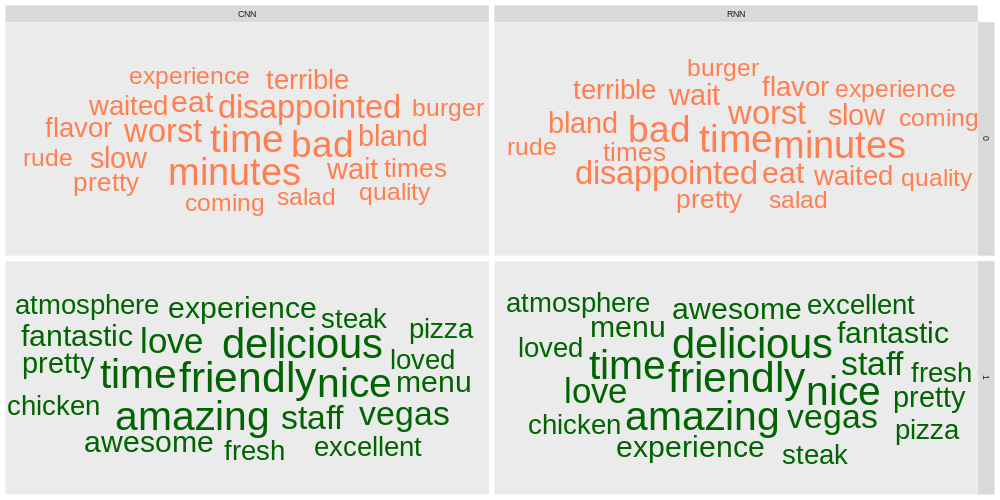

In [84]:
%%R -w 1000 -h 500
#install.packages("ggplot2")
#install.packages("ggwordcloud")
#install.packages("tidytext")
#install.packages("dplyr")
library(ggwordcloud)
library(tidytext)
library(dplyr)
stop_words <- tidytext::stop_words
stop_words <- rbind(
  data.table(stop_words),
  data.table(word=c("food", "service", "restaurant")), 
  fill=TRUE
)
dt_plot <- dt_pred %>%
    tidytext::unnest_tokens(word, sentence) %>%
    dplyr::anti_join(stop_words)
dt_plot <- melt(
  dt_plot, 
  id.vars = c("word", "true"), 
  measure.vars = c("pred_cnn", "pred_rnn"), 
  value.name = "sentiment",
  variable.name = "model"
)
dt_plot <- unique(dt_plot[,.(.N, sentiment=mean(sentiment)), by=.(word, true, model)])
setorder(dt_plot, true, model, -N)
dt_plot <- dt_plot[,idx:=1:.N,by=.(true,model)][idx<=20][,idx:=NULL]
levels(dt_plot$model) <- c("CNN", "RNN")
dt_plot[,sentiment:=factor(round(sentiment))]
ggplot(dt_plot, ggplot2::aes(label = word, size = N, colour=sentiment)) +
  geom_text_wordcloud() +
  scale_size_area(max_size = 15) +
  scale_colour_manual(
    guide=FALSE,
    values = c("coral", "darkgreen")
  ) +
  facet_grid(
    cols = vars(model),
    rows = vars(sentiment)
  )

# Annex

## Tuning using `ray.tune`

Initially I had tried to use `ray.tune` for tuning instead of building my own low-level grid search. Unfortunately, I could not get the package to run on Colab. 

In [ ]:
#!pip install ray
#!pip install tensorboardX
import ray
from ray import tune
import tensorflow.keras as keras
import inspect

In [ ]:
class TuneReporterCallback(keras.callbacks.Callback):
    """Tune Callback for Keras.
    
    The callback is invoked every epoch.
    """

    def __init__(self, logs={}):
        self.iteration = 0
        super(TuneReporterCallback, self).__init__()

    def on_epoch_end(self, batch, logs={}):
        self.iteration += 1
        tune.report(keras_info=logs, mean_accuracy=logs.get("accuracy"), mean_loss=logs.get("loss"))

In [ ]:
config={
    "filter_sizes": (3,4),
    "num_filters": tune.grid_search([100,150,200]),
    "dropout_prob": dropout_prob,
    "hidden_dims": tune.grid_search([100,150,200]),
    "num_layers": tune.grid_search([1,2,5]),
    "max_sequence_length": max_sequence_length,
    "embedding_layer": embedding_layer
}

In [ ]:
def tune_cnn(config): 
    model = create_cnn(
        filter_sizes=config['filter_sizes'], 
        num_filters=config['num_filters'],
        dropout_prob=config['dropout_prob'],
        hidden_dims=config['hidden_dims'],
        max_sequence_length=config['max_sequence_length'],
        embedding_layer=config['embedding_layer']
    ) 
    checkpoint_callback = ModelCheckpoint(
        "model.h5", monitor='loss', save_best_only=True, save_freq=2)

    # Enable Tune to make intermediate decisions by using a Tune Callback hook. This is Keras specific.
    callbacks = [checkpoint_callback, TuneReporterCallback()]
    
    # Train the model
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', 
              metrics=['accuracy'])

    model.fit(
        x_shuffled, y_shuffled, 
        batch_size=batch_size,
        epochs=num_epochs, 
        validation_split=val_split, 
        verbose=0,
        callbacks=callbacks
    )

In [ ]:
ray.shutdown()  # Restart Ray defensively in case the ray connection is lost. 
ray.init(log_to_driver=False)
# We clean out the logs before running for a clean visualization later.
! rm -rf ~/ray_results/tune_iris

analysis = tune.run(
    tune_cnn, 
    verbose=1, 
    config=config
)